# FINM 36700: Portfolio and Risk Management
## Homework 4
## Group 9

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import kurtosis, skew
from scipy.stats import norm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(rc={'figure.figsize':(15, 6)})

import matplotlib.pyplot as plt
import matplotlib.cm as cm

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Helper Functions

In [2]:
def performance_summary(return_data):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*12)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(12))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [3]:
def regression_based_performance(factor,fund_ret,rf,constant = True):
    """ 
        Returns the Regression based performance Stats for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            rf - Monthly risk free rate of return
        Output:
            summary_stats - (Beta of regression, treynor ratio, information ratio, alpha). 
    """
    if constant:
        X = sm.tools.add_constant(factor)
    else:
        X = factor
    y=fund_ret
    model = sm.OLS(y,X,missing='drop').fit()
    
    if constant:
        beta = model.params[1:]
        alpha = round(float(model.params['const']),6) *12

        
    else:
        beta = model.params
    treynor_ratio = ((fund_ret - rf).mean()*12)/beta[0]
    tracking_error = (model.resid.std()*np.sqrt(12))
    if constant:        
        information_ratio = model.params[0]*12/tracking_error
    r_squared = model.rsquared
    if constant:
        return (beta,treynor_ratio,information_ratio,alpha,r_squared,tracking_error,model.resid)
    else:
        return (beta,treynor_ratio,r_squared,tracking_error,model.resid)

In [4]:
def tangency_portfolio_rfr(asset_return,cov_matrix):
    """ 
        Returns the tangency portfolio weights in a (1 x n) vector when a riskless assset is available
        Inputs: 
            asset_return - Excess return over the risk free rate for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
    """
    asset_cov = np.array(cov_matrix)
    inverted_cov= np.linalg.inv(asset_cov)
    one_vector = np.ones(len(cov_matrix.index))
    
    den = (one_vector @ inverted_cov) @ (asset_return)
    num =  inverted_cov @ asset_return
    return (1/den) * num

# 2. The Factors

In [5]:
factors = pd.read_excel('dfa_analysis_data.xlsx',sheet_name = 'factors')
factors = factors.set_index('Date')
factors = factors.drop(['RF'], axis=1)
factors

,Mkt-RF,SMB,HML
Date,,,
1926-07-31,0.0296,-0.0256,-0.0243
1926-08-31,0.0264,-0.0117,0.0382
1926-09-30,0.0036,-0.0140,0.0013
1926-10-31,-0.0324,-0.0009,0.0070
1926-11-30,0.0253,-0.0010,-0.0051
...,...,...,...
2023-03-31,0.0251,-0.0551,-0.0885
2023-04-30,0.0061,-0.0335,-0.0004
2023-05-31,0.0035,0.0161,-0.0772


## 2.1 Calculate their univariate performance statistics

In [6]:
factor_summary = performance_summary(factors)
factor_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
Mkt-RF,0.081421,0.185140,0.439779,-0.08022
SMB,0.022779,0.109802,0.207459,-0.04206
HML,0.041191,0.123780,0.332780,-0.04210


In [7]:
sub_1980 = factors.loc[:'1980']
sub_2001 = factors.loc['1981':'2001']
sub_2023 = factors.loc['2002':]

df_dict={'1926-1980' : sub_1980,
         '1981-2001' : sub_2001,
         '2002-2023' : sub_2023}

summary_lst = []
for key in df_dict.keys():
    summary_stats = performance_summary(df_dict[key]).loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]
    summary_stats['Period'] = key
    summary_stats= summary_stats.reset_index().rename(columns = {'index':'Factor'}).set_index(['Period','Factor'])
    summary_lst.append(summary_stats)

factor_summary = pd.concat(summary_lst)
factor_summary

Mean  Volatility  Sharpe Ratio  VaR (0.05)
Period    Factor                                                
1926-1980 Mkt-RF  0.081138    0.205050      0.395696   -0.083985
          SMB     0.033985    0.114568      0.296638   -0.043400
          HML     0.049479    0.133825      0.369727   -0.042910
1981-2001 Mkt-RF  0.077257    0.157396      0.490847   -0.064545
          SMB    -0.000862    0.118346     -0.007283   -0.046515
          HML     0.063776    0.111183      0.573612   -0.041790
2002-2023 Mkt-RF  0.086187    0.155313      0.554923   -0.079130
          SMB     0.017486    0.086443      0.202280   -0.038230
          HML    -0.001710    0.107517     -0.015901   -0.041740

## 2.2 Based on the factor statistics above, answer the following

### 2.2.a) Does each factor have a premium (positive expected excess return) in each subsample?

All 3 factors possess positive premiums in the sub period leading to 1980. Between 1981-2001 the Size factor provides no mean excess returns (discount of 8 basis points), but recovers to provide some premium again between 2002 and 2022. Similarly, the Value factor, provides premium up untill 2001, but the mean excess returns reduce significantly for the period between 2001 and 2022, with negative returns. The Market factor consistently provides positive premium throughout the period of analysis.

### 2.2.b) Does the premium to the size factor get smaller after 1980?

The premium of the size factor does decline after 1980, going almost to 0 between 1981 and 2001 and then recovering to ~1.7%.

### 2.2.c) Does the premium to the value factor get smaller during the 1990’s?

The premium to value factor increases in the sub-sample of 1981-2001 as compared to 1926-1980, but then experiences a significant decline post 2002. The tech bubble in the late 1990s and early 2000s had a huge influence on the spread, as the value factor experienced significant drawdowns.

### 2.2.d) How have the factors performed since the time of the case, (2002-present)?

Since 2002, the Market Factor has posted highest premiums between the three subsamples. While the Size factor also posted a premium, the value factor is in a deep drawdown.

## 2.3 Report the correlation matrix across the three factors

Text(0.5, 1.0, 'Factors Correlation Heatmap')

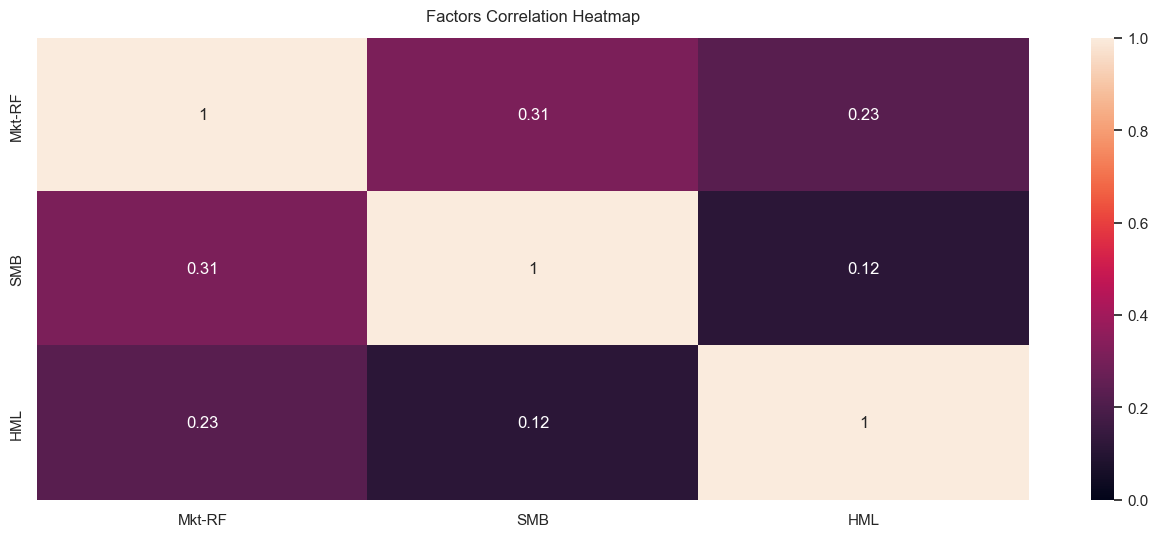

In [8]:
factor_corr = factors.corr()

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(factor_corr, vmin=0, vmax=1, annot=True)
heatmap.set_title('Factors Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

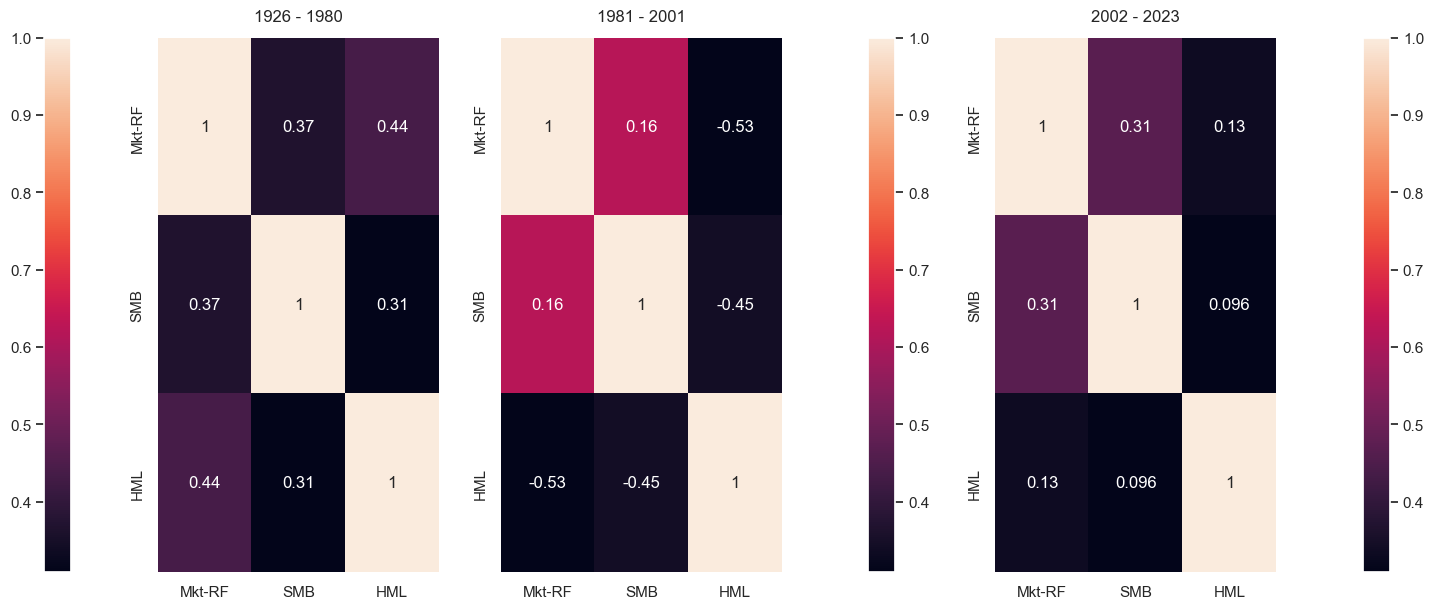

In [9]:
fig, (ax,ax2,ax3) = plt.subplots(ncols=3)

fig.subplots_adjust(wspace=0.01)
fig.tight_layout(pad=1)
sns.heatmap(sub_1980.corr(), ax=ax, cbar=False, annot = True).set_title('1926 - 1980', fontdict={'fontsize':12}, pad=12)

fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(sub_2001.corr(), ax=ax2, cbar=False, annot = True).set_title('1981 - 2001', fontdict={'fontsize':12}, pad=12)

fig.colorbar(ax.collections[0],ax=ax2,location="right", use_gridspec=False, pad=0.2)

sns.heatmap(sub_2023.corr(), ax=ax3, cbar=False, annot = True).set_title('2002 - 2023', fontdict={'fontsize':12}, pad=12)
fig.colorbar(ax.collections[0],ax=ax3,location="right", use_gridspec=False, pad=0.2)

fig.set_figwidth(15)
plt.show()

Overall, the correlations between the three factors are low and thus the construction method succeeds in its objective.

## 2.4 Plot the cumulative returns of the three factors. Create plots for the 1981-2001 subsample as well as the 2002-Present subsample.

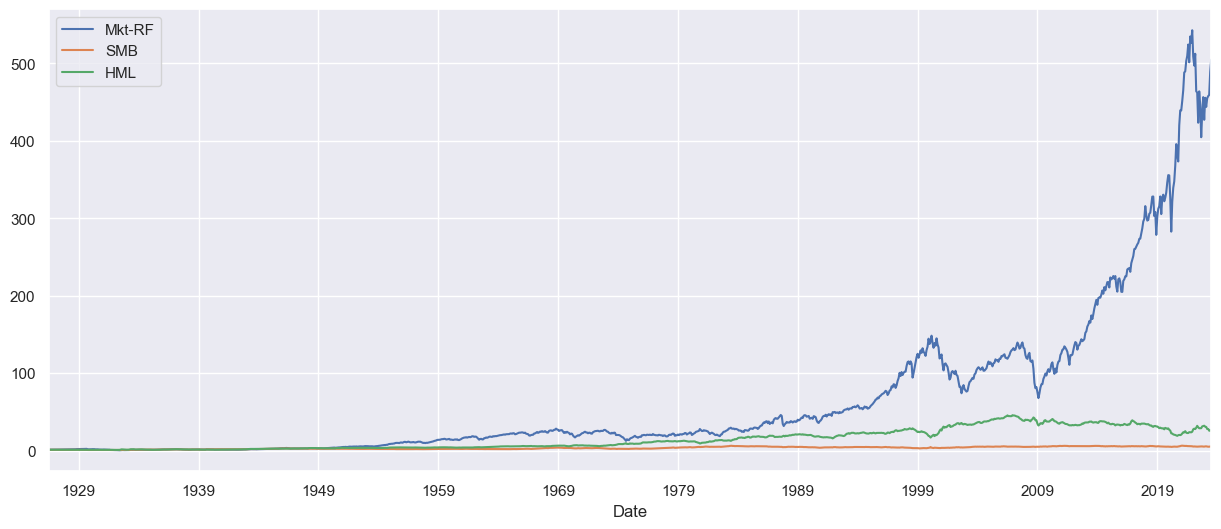

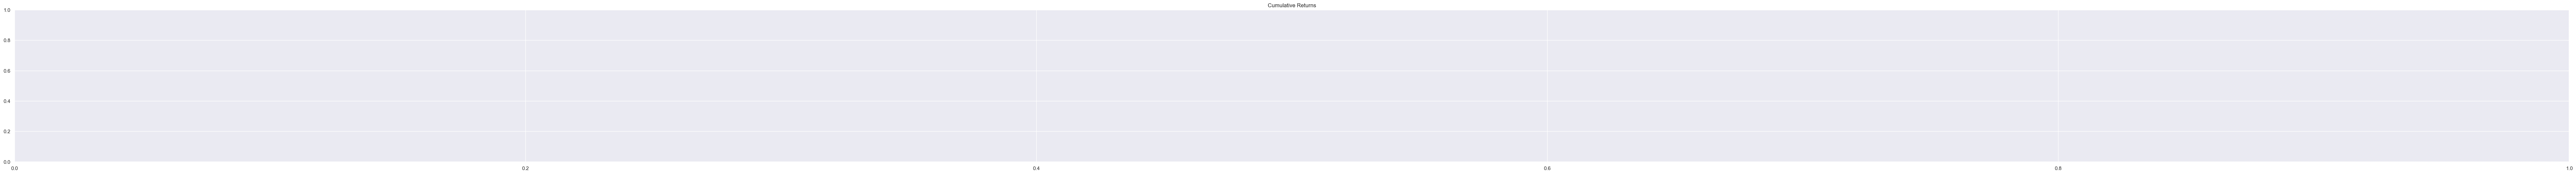

In [18]:
figure = ((factors + 1).cumprod()).plot()
plt.figure(figsize=(100, 6))
plt.show()

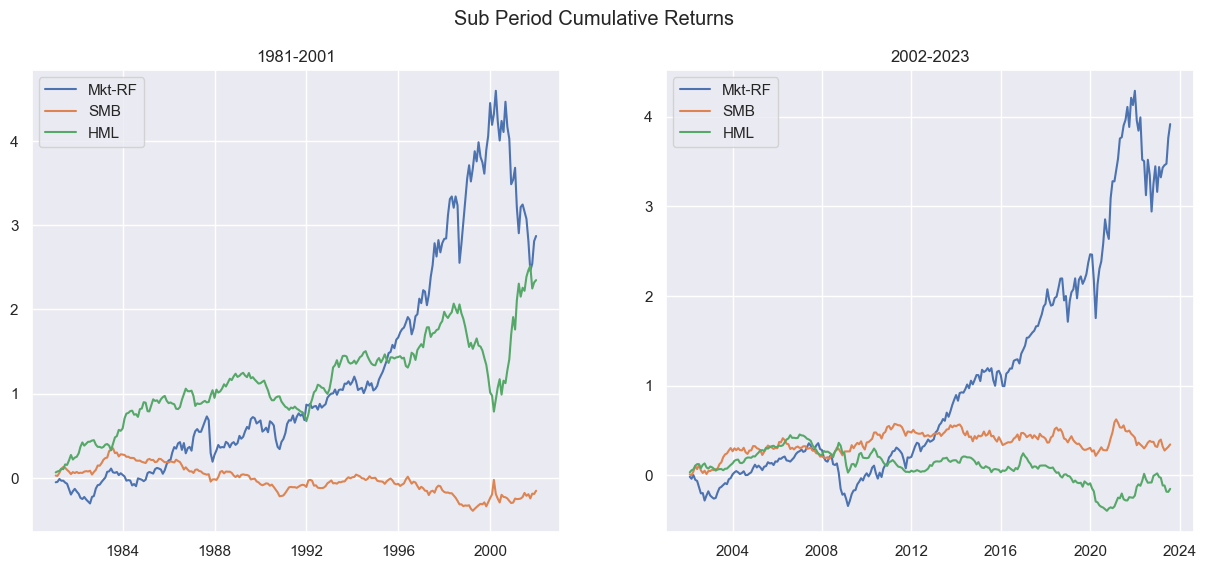

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sub Period Cumulative Returns')
ax1.plot(((sub_2001 + 1).cumprod() - 1))
ax2.plot(((sub_2023 + 1).cumprod() - 1))

fig.set_figwidth(15)
ax1.legend(sub_2001.columns)
ax2.legend(sub_2023.columns)

ax1.title.set_text('1981-2001')
ax2.title.set_text('2002-2023')

### 2.5 Does it appear that all three factors were valuable in 1981-2001? And post-2001? Would you advise DFA to continue emphasizing all three factors?

As the graph showed above, market factor was generally valuable over time, though with some drawdowns in the 2001 tech bubble burst, the 2008 financial crisis and the covid recently. In late 2001, the value factor benefited from the depressed stock prices to post a premium, but contributed barly excess return post that. For the Size factor, it posts near zero or negative returns for the entire period.

Since the value and size factors seem to lose the power recently, DFA should try to figure out more other factors.

# 3. CAPM

In [12]:
port_ret = pd.read_excel('dfa_analysis_data.xlsx',sheet_name = 'portfolios (total returns)')
port_ret = port_ret.set_index('Date')

rf = pd.read_excel('dfa_analysis_data.xlsx',sheet_name = 'factors')
rf = rf.set_index('Date')
rf = rf['RF'].to_frame()
port_ret = port_ret.merge(rf['RF'], on = rf.index).fillna(0).rename(columns={'key_0' : 'Date'})
port_ret.index = port_ret['Date']
port_ret = port_ret.drop(['Date'], axis=1)
for col in port_ret.columns:
    port_ret[col] = port_ret[col] - port_ret['RF']


port_ret = port_ret.drop(['RF'], axis=1)
port_ret

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.056048,-0.019206,0.002675,-0.016780,0.018334,0.009877,0.021992,0.002726,-0.028249,-0.005544,...,0.013693,0.013078,0.010778,0.000527,0.022478,0.032339,0.058702,0.018066,0.028911,0.003423
1926-08-31,-0.022706,-0.082782,0.011296,0.012106,0.081468,0.021118,-0.014349,0.037584,0.002538,0.059175,...,0.010836,0.036230,0.017521,0.019206,0.050922,0.007624,0.039403,0.017631,0.052349,0.075076
1926-09-30,-0.050591,-0.028454,-0.045717,-0.035029,0.006349,-0.028840,-0.014918,0.008529,-0.037780,-0.011701,...,0.008623,-0.007550,-0.019936,0.012346,0.006430,-0.015206,0.034238,-0.001350,-0.009787,-0.026584
1926-10-31,-0.096929,-0.038719,-0.038148,0.031213,-0.028676,-0.031269,-0.035863,-0.053945,-0.083391,-0.016413,...,-0.036561,-0.029759,-0.024270,-0.034251,-0.056725,-0.030613,-0.033271,-0.025637,-0.049919,-0.061329
1926-11-30,0.052788,0.038777,0.021523,-0.047594,0.002262,0.027933,-0.026790,0.026978,0.048446,0.024192,...,0.031348,0.020787,0.034235,0.046220,0.015113,0.039846,0.022226,0.012104,0.033519,0.022536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,-0.109182,-0.066877,-0.073182,-0.075685,-0.101450,-0.034787,-0.035647,-0.039695,-0.053914,-0.107226,...,0.008937,-0.007249,-0.024202,-0.041774,-0.125767,0.078593,0.027489,0.006449,-0.041318,-0.069981
2023-04-30,0.022165,-0.023873,-0.019145,-0.030808,-0.045158,-0.032781,-0.000935,-0.035672,-0.032745,-0.032602,...,-0.022491,-0.025691,-0.007201,-0.019789,-0.001119,0.008119,0.009846,0.008361,0.020182,0.032536
2023-05-31,0.044331,0.021441,0.028737,-0.014628,-0.021867,0.007839,0.030623,0.017169,0.016223,-0.053010,...,-0.002017,-0.026846,-0.043499,-0.034998,-0.067785,0.052113,-0.015659,-0.054386,-0.076495,-0.050559


## 3.1 Summary Statistics

In [13]:
port_summary = performance_summary(port_ret.loc['1981-01-01':])
port_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
SMALL LoBM,0.008607,0.272612,0.031572,-0.121077
ME1 BM2,0.091784,0.235700,0.389411,-0.095709
ME1 BM3,0.092669,0.197915,0.468227,-0.085817
ME1 BM4,0.117387,0.192404,0.610105,-0.076442
SMALL HiBM,0.129434,0.208295,0.621397,-0.088647
ME2 BM1,0.059889,0.244792,0.244654,-0.103985
ME2 BM2,0.101862,0.204197,0.498842,-0.084928
ME2 BM3,0.107086,0.184794,0.579484,-0.079119
ME2 BM4,0.108899,0.180701,0.602648,-0.077423
ME2 BM5,0.116268,0.213841,0.543715,-0.096701


### Can the difference in mean excess returns of the portfolios be explained by differences in their volatilities? Or by their VaR(.05) statistics?

From the chart, we could not see a clear evidence that the excess returns can be explained by differences in volatilities or VaR statistics

## 3.2 CAPM

### 3.2.1 For each of the n = 25 test portfolios, run the CAPM time-series regression

In [14]:
portfolios = port_ret.columns
factor = factors['1981-01-01':]['Mkt-RF']

df_lst= []
for port in portfolios:
    fund_ret = port_ret['1981-01-01':][port]
    reg = regression_based_performance(factor,fund_ret,0)
    beta = reg[0][0]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst.append(pd.DataFrame([[beta,alpha,r_squared,treynor_ratio,information_ratio]],columns=['Market Beta','Alpha','R-Squared','Treynor Ratio','Information Ratio'],index = [port]))


### 3.2.2 Report the regression statistics

In [15]:
reg_performance = pd.concat(df_lst)
reg_performance

,Market Beta,Alpha,R-Squared,Treynor Ratio,Information Ratio
SMALL LoBM,1.350120,-0.101808,0.598400,0.006375,-0.589319
ME1 BM2,1.160335,-0.003108,0.591270,0.079101,-0.020651
ME1 BM3,1.034045,0.008100,0.665975,0.089618,0.070829
ME1 BM4,0.967278,0.038280,0.616611,0.121358,0.321317
SMALL HiBM,0.988304,0.048612,0.549235,0.130966,0.347576
ME2 BM1,1.333429,-0.049164,0.723908,0.044914,-0.382220
ME2 BM2,1.128858,0.009540,0.745617,0.090235,0.092637
ME2 BM3,1.024793,0.023280,0.750294,0.104495,0.252046
ME2 BM4,0.970403,0.029532,0.703593,0.112220,0.300229
ME2 BM5,1.109383,0.025536,0.656627,0.104805,0.203817


### 3.2.3 If (CAPM) were true, what would be true of the Treynor Ratios, alphas, and Information Ratios?

If CAPM were true, the Treynor Ratios should be the same across all portfolios, close to the expectation of market excess return, and the alphas should be zero. The information ratios should relate to idiosyncratic risk.

## 3.3 Cross-sectional Estimation

### Report the intercept, the regression coefficient and the R-Squared

In [16]:
fund_ret = port_ret.loc['1981-01-01':].mean()
factor = reg_performance['Market Beta']
reg = regression_based_performance(factor,fund_ret,0)
beta = reg[0][0]
treynor_ratio = reg[1]
information_ratio = reg[2]
alpha = reg[3]
r_squared = reg[4]
cross_sec_reg = pd.DataFrame([[beta,alpha/12,r_squared]],columns=['Beta','Alpha','R-Squared'],index = ['Cross-Sectional Estimation'])
cross_sec_reg


,Beta,Alpha,R-Squared
Cross-Sectional Estimation,-0.008656,0.016986,0.272833


### What would these three statistics be if (CAPM) were true?

The Beta should be the expected excess returns of the market factor, and the alpha should be close to zero. And the R-squared should be high as well, since the dependent variable is mean returns instead of realized returns.

## 3.4 Broadly speaking, do these results support DFA’s belief in size and value portfolios containing premia unrelated to the CAPM?

Yes. These results show that CAPM is not strictly held, with low Beta, low R-Squared and relatively high Alpha. It means that there should be other factors to explain the excess returns of portfolios. So the size and value factor could contain premia unrelated to the CAPM.